In [1]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import errno
import numpy as np
import sys
import zipfile
import scipy.io as sio
import torch.utils.data as data
import glob

class UCSD(data.Dataset):
    """UCSD pedestrian counting data."""

    def __init__(self, data_dir, annotation_dir, transform=None, in_memory=False):

        self.file_list = []
        self.file_cnts = []
        
        self.in_memory = in_memory
        
        files = glob.glob(
            os.path.join(
                annotation_dir, 
                '*count_roi_mainwalkway.mat'))
        
        for f in files:
            tmp = sio.loadmat(f)
            
            l_count = tmp['count'][0][0].ravel()
            r_count = tmp['count'][0][1].ravel()
            t_count = l_count + r_count
            
            [self.file_cnts.append(c) for c in t_count]
            
            file_parts = os.path.basename(f).split('_')
            seq_id = "_".join(file_parts[0:3])
            
            for i in np.arange(len(t_count)):
                
                img_name = os.path.join(
                        data_dir,
                        seq_id + ".y",
                        "{}_f{:03d}.png".format(seq_id,i+1))
                
                if in_memory:
                    img = Image.open(img_name)
                    img = img.resize((250,250))
                    self.file_list.append(img)
                else:
                    self.file_list.append(img_name)
            
            self.transform = transform

    def __len__(self):
        return len(self.file_list)
        
    def __getitem__(self, idx):
        
        if self.in_memory:
            img = self.file_list[idx]
        else:
            img_name = self.file_list[idx]
            img = Image.open(img_name)
            img = img.resize((250,250))

        if self.transform:
            img = self.transform(img)
        return img, self.file_cnts[idx]

In [2]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

class CountingCNN(nn.Module):

    def __init__(self, num_classes=1000):
        super(CountingCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [3]:
import torch
import random

class SubsetSampler(object):

    def __init__(self, subset):
        self.subset = subset

    def __iter__(self):
        return iter(self.subset)

    def __len__(self):
        return len(self.subset)


class RandomSubsetSampler(object):

    def __init__(self, data_source, train_share=0.8):

        # Generate a list of indizes reaching from 0 ... len(data_source)-1
        idxList = list(range(0,len(data_source)))

        # Ensure that list is sorted randomly
        random.shuffle(idxList)

        # Split dataset random shares of train and test data
        numberOfTrainSamples = int(len(data_source) / (1 / train_share))
        
        self.train_samples = idxList[:numberOfTrainSamples]
        self.test_samples = idxList[numberOfTrainSamples:]


    def trainSampler(self):
        return SubsetSampler(self.train_samples)

    def testSampler(self):
        return SubsetSampler(self.test_samples)

In [4]:
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets
import torchvision.models as models


transformsData = transforms.Compose([transforms.ToTensor()] )

dataset = UCSD( data_dir='/home/ec2-user/ml_data/uni/dbs/ucsd/ucsdpeds/vidf', 
                annotation_dir='/home/ec2-user/ml_data/uni/dbs/ucsd/vidf-cvpr', 
                transform=transformsData,
                in_memory=True )

sampler = RandomSubsetSampler(dataset)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=20, sampler=sampler.trainSampler(), num_workers=2 )
testloader = torch.utils.data.DataLoader(dataset, batch_size=20, sampler=sampler.testSampler(), num_workers=2)

net = CountingCNN(num_classes=50)
net.cuda()

learningRate = 0.1

performance_statistic = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learningRate)

print("Start training")
for epoch in range(150):
    
    running_loss = 0.0
    for data in trainloader:
        
        # get the inputs
        inputs, labels = data
        labels = labels.long()
        
        inputs = inputs.cuda()
        labels = labels.cuda()
  
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Keep track of the loss for reporting purpose
        running_loss += loss.data[0]
    
    # Lower learning rate every 50th epoch
    if epoch % 50 == 0:
        learningRate /= 2
        optimizer = optim.SGD(net.parameters(), lr=learningRate)
        
    print( str(epoch) + ": " + str(loss.data[0]))

    total_diff = 0.0
    total_squared_diff = 0.0
    correct = 0
    total_nr = 0
    
    # Evaluate performance
    for data in testloader:
  
        inputs, labels = data
        labels = labels.long()
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        outputs = net(Variable(inputs))
        _, predicted = torch.max(outputs.data, 1)
   
        # Compute MAE, MSE and accuracy
        diff = predicted - labels
            
        squared_diff = diff.float().pow(2)
        squared_diff = squared_diff.sum()
                                    
        diff = diff.abs()
        diff = diff.sum()
        
        correct += (predicted == labels).sum()
        total_squared_diff += squared_diff
        total_diff += diff
        total_nr += labels.size(0)
        
        
    accuracy = correct / total_nr
    mae = total_diff / total_nr
    mse = total_squared_diff / total_nr

    print('Accuracy: %f' % (accuracy*100))
    print('Mean Absolute Error: %f' % mae)
    print('Mean Squared Error: %f' % mse)
    
    # Keep track of the performance to report on performance
    performance_statistic.append((running_loss,mae,mse,accuracy))

print('Finished Training')


Start training
0: 3.6399242877960205
Accuracy: 5.250000
Mean Absolute Error: 6.245000
Mean Squared Error: 73.365000
1: 3.528214693069458
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
2: 3.493332624435425
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
3: 3.4934535026550293
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
4: 3.492047071456909
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
5: 3.489405870437622
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
6: 3.4842288494110107
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
7: 3.476461887359619
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
8: 3.4751086235046387
Accuracy: 5.750000
Mean Absolute Error: 6.550000
Mean Squared Error: 65.525000
9: 3.5097317695617676
Accuracy: 5.750000
Mean Absolute Error: 6.580000
Mean Squar

80: 0.3468589782714844
Accuracy: 81.000000
Mean Absolute Error: 0.202500
Mean Squared Error: 0.227500
81: 0.00686225900426507
Accuracy: 81.000000
Mean Absolute Error: 0.195000
Mean Squared Error: 0.205000
82: 0.005221843719482422
Accuracy: 79.750000
Mean Absolute Error: 0.212500
Mean Squared Error: 0.232500
83: 0.005600261501967907
Accuracy: 82.000000
Mean Absolute Error: 0.190000
Mean Squared Error: 0.210000
84: 0.03647298738360405
Accuracy: 81.750000
Mean Absolute Error: 0.192500
Mean Squared Error: 0.212500
85: 0.015504551120102406
Accuracy: 80.500000
Mean Absolute Error: 0.222500
Mean Squared Error: 0.382500
86: 0.003066635224968195
Accuracy: 78.500000
Mean Absolute Error: 0.302500
Mean Squared Error: 1.027500
87: 0.00973367691040039
Accuracy: 81.000000
Mean Absolute Error: 0.220000
Mean Squared Error: 0.420000
88: 0.2420753538608551
Accuracy: 78.750000
Mean Absolute Error: 0.325000
Mean Squared Error: 1.345000
89: 0.004658984951674938
Accuracy: 81.250000
Mean Absolute Error: 0.237

Model Performance (based on Min Loss):
	 Min Loss: 0.08189783073055423
	 MAE: 0.3
	 MSE: 1.705



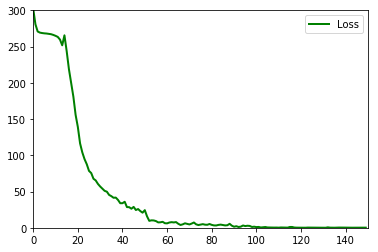

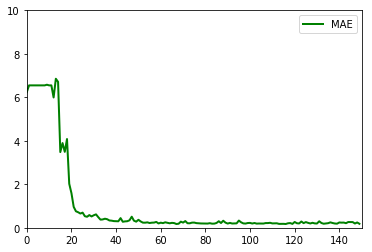

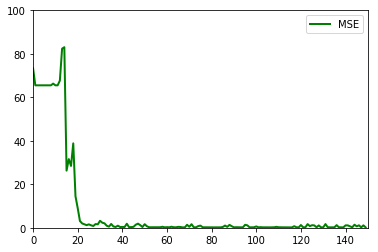

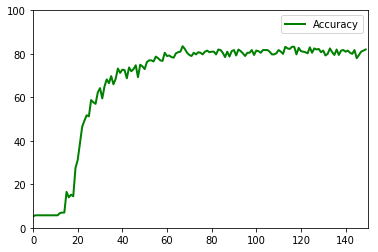

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle

def plot(plt, values, line_spec='g', label=None):
    
    y_values = values
    x_values = list(range(len(values)))
    
    if label is None:
        plt.plot(x_values, y_values, line_spec, linewidth=2.0)
    else:
        plt.plot(x_values, y_values, line_spec, label=label, linewidth=2.0)
        plt.legend()
          

loss_lst, mae_lst, mse_lst, acc_lst = zip(*performance_statistic)

loss_lst = list(loss_lst)
mae_lst = list(mae_lst)
mse_lst = list(mse_lst)
acc_lst = list(acc_lst)
acc_lst = list(map(lambda x : x*100, acc_lst) )

max_epoch = 150
max_loss = 300
max_mae = 10
max_mse = 100
max_acc = 100

# Plot the loss of every network
plt.figure()
plt.axis([0,max_epoch,0,max_loss])

plot(plt,loss_lst, 'g', 'Loss')

# Plot the MAE of every network
plt.figure()
plt.axis([0,max_epoch,0,max_mae])

plot(plt,mae_lst, 'g', 'MAE')

# Plot the MSE of every network
plt.figure()
plt.axis([0,max_epoch,0,max_mse])

plot(plt,mse_lst, 'g', 'MSE')

# Plot the Accuracy of every network
plt.figure()
plt.axis([0,max_epoch,0,max_acc])

plot(plt,acc_lst, 'g', 'Accuracy')


print("Model Performance (based on Min Loss):")
min_loss = min(loss_lst)
min_loss_idx = loss_lst.index(min_loss)

print("\t Min Loss: " + str(min_loss))
print("\t MAE: " + str(mae_lst[min_loss_idx]))
print("\t MSE: " + str(mse_lst[min_loss_idx]))
print()
